Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hydroeval as he

Model Library

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

Hyper Parameter Tuner

In [3]:
import keras_tuner as kt
import time

# Model Checkpoint

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Load Dataset

In [5]:
df = pd.read_csv('preprocessed_dataset_kathmandu.csv',index_col=0)

In [6]:
df.head()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
date_and_time,,,,,,
2019-01-01 00:00:00,0.098577,0.000000,0.060150,0.814545,0.243077,0.0
2019-01-01 01:00:00,0.114837,0.000000,0.112782,0.847273,0.243077,0.0
2019-01-01 02:00:00,0.137195,0.008475,0.150376,0.880000,0.264615,0.0
2019-01-01 03:00:00,0.178862,0.033898,0.285714,0.909091,0.332308,0.0
2019-01-01 04:00:00,0.197154,0.161017,0.394737,0.916364,0.252308,0.0


In [7]:
features = ["PM2.5","O3","TEMPERATURE","PRESSURE","DEWPOINT","RAIN"]
df = df[features]

In [8]:
mean_pm = df['PM2.5'].mean()
std_pm = df['PM2.5'].std()
z_scores = (df['PM2.5'] - mean_pm) / std_pm
threshold = 3
df = df[np.abs(z_scores) < threshold]

Adding Window 

In [9]:

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df,WINDOW_SIZE)

X.shape, y.shape    

((7564, 2, 6), (7564,))

Import

In [10]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from tensorflow.keras import layers

Developing Transformer Model

In [11]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for i in range(hp.Int('num_transformer_blocks', min_value=2, max_value=8, step=2)):
        x = transformer_encoder(x,
                               hp.Int('head_size', min_value=8, max_value=256, step=32),
                               hp.Int('num_heads', min_value=2, max_value=16),
                               hp.Int('ff_dim', min_value=4, max_value=64),
                               hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for i in range(hp.Int('num_mlp_layers', min_value=1, max_value=3)):
        x = layers.Dense(hp.Int(f'mlp_units_{i}', min_value=32, max_value=256, step=32))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.6))(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Choose optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mae', RootMeanSquaredError()])

    return model

In [12]:
input_shape = X.shape[1:]
input_shape

(2, 6)

importing for training

In [13]:
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt

C:\Users\Dell\AppData\Local\Temp\ipykernel_2828\3676148075.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


Model Building

In [14]:

# Define your input shape
input_shape = X.shape[1:]


# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        tuner = kt.RandomSearch(
            build_model,
            objective='val_loss',
            max_trials=5,
            # directory=f'C:\Users\Acer\Desktop\TR tuner val/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            # project_name=f'C:\Users\Acer\Desktop\TR tuner val/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'
            
            #directory=f'/content/drive/MyDrive/research/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            #project_name=f'/content/drive/MyDrive/research/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'
            directory = f'C:/Users/Dell/Desktop/MP/tr tuning ktm/Hp_Tr_Kathmandu/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            project_name = f'C:/Users/Dell/Desktop/MP/tr tuning ktm/Hp_Tr_Kathmandu/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'
        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        # tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)  # Adjust epochs as needed
        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = build_model(best_hps)
        es = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_squared_error(y_val, y_pred)

         # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    nse_best = he.evaluator(he.nse, y_pred_best, y_test_outer)
    kge_best, r, alpha, beta = he.evaluator(he.kge, y_pred_best, y_test_outer)
    print("Best Model:")

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    nse_worst = he.evaluator(he.nse, y_pred_worst, y_test_outer)
    kge_worst, r, alpha, beta = he.evaluator(he.kge, y_pred_worst, y_test_outer)
    print("Worst Model:")
    print("KGE : ", kge_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)


# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']},time: {scores['Worst Model']['testing time']}")

Reloading Tuner from C:/Users/Dell/Desktop/MP/tr tuning ktm/Hp_Tr_Kathmandu/hyperparameter_random_tuning_fold_tf_0_0\tuner0.json
Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001DE7B5666A0>
Epoch 1/10
127/127 [==============================] - 29s 40ms/step - loss: 0.0086 - mae: 0.0627 - root_mean_squared_error: 0.0927 - val_loss: 0.0013 - val_mae: 0.0258 - val_root_mean_squared_error: 0.0357
Epoch 2/10
127/127 [==============================] - 4s 31ms/step - loss: 0.0027 - mae: 0.0390 - root_mean_squared_error: 0.0524 - val_loss: 0.0016 - val_mae: 0.0315 - val_root_mean_squared_error: 0.0406
Epoch 3/10
127/127 [==============================] - 4s 29ms/step - loss: 0.0023 - mae: 0.0359 - root_mean_squared_error: 0.0482 - val_loss: 0.0013 - val_mae: 0.0277 - val_root_mean_squared_error: 0.0363
Epoch 4/10
127/127 [==============================] - 4s 34ms/step - loss: 0.0018 - mae: 0.0320 - root_mean_squared_erro

c:\Users\Dell\Desktop\MP\myenv\lib\site-packages\hydroeval\objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


Epoch 1/10
127/127 [==============================] - 32s 53ms/step - loss: 0.0017 - mae: 0.0294 - root_mean_squared_error: 0.0417 - val_loss: 6.9281e-04 - val_mae: 0.0201 - val_root_mean_squared_error: 0.0263
Epoch 2/10
127/127 [==============================] - 4s 30ms/step - loss: 8.1731e-04 - mae: 0.0214 - root_mean_squared_error: 0.0286 - val_loss: 6.8203e-04 - val_mae: 0.0188 - val_root_mean_squared_error: 0.0261
Epoch 3/10
127/127 [==============================] - 3s 25ms/step - loss: 6.5800e-04 - mae: 0.0190 - root_mean_squared_error: 0.0257 - val_loss: 4.8671e-04 - val_mae: 0.0160 - val_root_mean_squared_error: 0.0221
Epoch 4/10
127/127 [==============================] - 4s 29ms/step - loss: 5.5187e-04 - mae: 0.0174 - root_mean_squared_error: 0.0235 - val_loss: 4.9201e-04 - val_mae: 0.0160 - val_root_mean_squared_error: 0.0222
Epoch 5/10
127/127 [==============================] - 3s 27ms/step - loss: 4.6768e-04 - mae: 0.0158 - root_mean_squared_error: 0.0216 - val_loss: 3.380

c:\Users\Dell\Desktop\MP\myenv\lib\site-packages\hydroeval\objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


Epoch 1/10
127/127 [==============================] - 64s 107ms/step - loss: 0.0092 - mae: 0.0653 - root_mean_squared_error: 0.0957 - val_loss: 0.0014 - val_mae: 0.0265 - val_root_mean_squared_error: 0.0380
Epoch 2/10
127/127 [==============================] - 10s 81ms/step - loss: 0.0016 - mae: 0.0302 - root_mean_squared_error: 0.0400 - val_loss: 0.0012 - val_mae: 0.0255 - val_root_mean_squared_error: 0.0345
Epoch 3/10
127/127 [==============================] - 10s 83ms/step - loss: 0.0012 - mae: 0.0270 - root_mean_squared_error: 0.0351 - val_loss: 0.0011 - val_mae: 0.0251 - val_root_mean_squared_error: 0.0335
Epoch 4/10
127/127 [==============================] - 9s 75ms/step - loss: 0.0011 - mae: 0.0256 - root_mean_squared_error: 0.0333 - val_loss: 9.4672e-04 - val_mae: 0.0234 - val_root_mean_squared_error: 0.0308
Epoch 5/10
127/127 [==============================] - 9s 73ms/step - loss: 9.4431e-04 - mae: 0.0233 - root_mean_squared_error: 0.0307 - val_loss: 7.7377e-04 - val_mae: 0.02

c:\Users\Dell\Desktop\MP\myenv\lib\site-packages\hydroeval\objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


Best hyperparameters for fold 0: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000001DE7DD13BE0>
Epoch 1/10
127/127 [==============================] - 60s 94ms/step - loss: 0.0091 - mae: 0.0513 - root_mean_squared_error: 0.0954 - val_loss: 0.0011 - val_mae: 0.0254 - val_root_mean_squared_error: 0.0335
Epoch 2/10
127/127 [==============================] - 7s 52ms/step - loss: 0.0015 - mae: 0.0287 - root_mean_squared_error: 0.0386 - val_loss: 0.0011 - val_mae: 0.0257 - val_root_mean_squared_error: 0.0331
Epoch 3/10
127/127 [==============================] - 7s 52ms/step - loss: 0.0012 - mae: 0.0270 - root_mean_squared_error: 0.0353 - val_loss: 0.0011 - val_mae: 0.0257 - val_root_mean_squared_error: 0.0331
Epoch 4/10
127/127 [==============================] - 6s 44ms/step - loss: 0.0012 - mae: 0.0267 - root_mean_squared_error: 0.0349 - val_loss: 0.0011 - val_mae: 0.0257 - val_root_mean_squared_error: 0.0331
Epoch 5/10
127/127 [========================

c:\Users\Dell\Desktop\MP\myenv\lib\site-packages\hydroeval\objective_functions.py:80: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


In [15]:
history = model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            callbacks=[es],
        )

Epoch 1/10
127/127 [==============================] - 7s 53ms/step - loss: 6.0311e-04 - mae: 0.0184 - root_mean_squared_error: 0.0246 - val_loss: 3.6607e-04 - val_mae: 0.0138 - val_root_mean_squared_error: 0.0191
Epoch 2/10
127/127 [==============================] - 6s 49ms/step - loss: 4.9600e-04 - mae: 0.0162 - root_mean_squared_error: 0.0223 - val_loss: 5.7173e-04 - val_mae: 0.0187 - val_root_mean_squared_error: 0.0239
Epoch 3/10
127/127 [==============================] - 5s 43ms/step - loss: 5.4462e-04 - mae: 0.0172 - root_mean_squared_error: 0.0233 - val_loss: 5.1577e-04 - val_mae: 0.0166 - val_root_mean_squared_error: 0.0227
Epoch 4/10
127/127 [==============================] - 6s 46ms/step - loss: 5.1672e-04 - mae: 0.0168 - root_mean_squared_error: 0.0227 - val_loss: 3.1891e-04 - val_mae: 0.0127 - val_root_mean_squared_error: 0.0179
Epoch 5/10
127/127 [==============================] - 6s 45ms/step - loss: 4.8931e-04 - mae: 0.0163 - root_mean_squared_error: 0.0221 - val_loss: 2.

Nested Cross Validation Scores

In [17]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Worst Model']['MSE']}, R^2: {scores['Worst Model']['R^2']}, RMSE: {scores['Worst Model']['RMSE']}, MAE: {scores['Worst Model']['MAE']}, time: {scores['Worst Model']['testing time']}")

# Calculate overall statistics
all_mse = [scores['Worst Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Worst Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Worst Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Worst Model']['R^2'] for scores in nested_scores]
all_time = [scores['Worst Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0009298414974463048, R^2: 0.18636565176210274, RMSE: 0.03049330250147243, MAE: 0.023376570599244497, time: 1.6578450202941895

Fold 2 - MSE: 0.0010946751153012846, R^2: -0.005125071112225488, RMSE: 0.033085874860751145, MAE: 0.02608312480803233, time: 2.194035768508911

Fold 3 - MSE: 0.0010893448503521126, R^2: -0.002032552173302893, RMSE: 0.03300522459175384, MAE: 0.025708685527754783, time: 3.4728384017944336

Fold 4 - MSE: 0.0010841659788624685, R^2: -0.0025994401198823347, RMSE: 0.032926675794292815, MAE: 0.025495614395191657, time: 4.471161365509033

Fold 5 - MSE: 0.0010571468487454946, R^2: -0.0008229297859700946, RMSE: 0.03251379474539222, MAE: 0.024691075297079666, time: 6.604595899581909
Mean MSE: 0.001
Mean MAE: 0.025
Mean RMSE: 0.032
Mean R^2: 0.035
Mean time: 3.680


Using Nested_scores as needed

In [18]:
# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']},time: {scores['Worst Model']['testing time']}")

# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.6f}")
print(f"Mean MAE: {mean_mae:.6f}")
print(f"Mean RMSE: {mean_rsme:.6f}")
print(f"Mean R^2: {mean_r2:.6f}")
print(f"Mean time: {mean_time:.6f}")


Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0003530932430946494, R^2: 0.6910346639706619, RMSE: 0.018790775478799416, MAE: 0.01324729434491273,time: 1.6578450202941895

Fold 2 - MSE: 0.00033955068398072616, R^2: 0.6882263051276181, RMSE: 0.0184269010954291, MAE: 0.01281841067355885,time: 2.194035768508911

Fold 3 - MSE: 0.0002962041258944133, R^2: 0.7275369905697873, RMSE: 0.017210581799997734, MAE: 0.01161748163953531,time: 3.4728384017944336

Fold 4 - MSE: 0.0002799085902146623, R^2: 0.7411501547683541, RMSE: 0.016730468917955117, MAE: 0.01150904701540814,time: 4.471161365509033

Fold 5 - MSE: 0.00030412754412126227, R^2: 0.7120761225394034, RMSE: 0.017439252969128644, MAE: 0.011631907386038733,time: 6.604595899581909
Mean MSE: 0.000315
Mean MAE: 0.012165
Mean RMSE: 0.017720
Mean R^2: 0.712005
Mean time: 3.680095


Graph Plotting

237/237 [==============================] - 4s 15ms/step


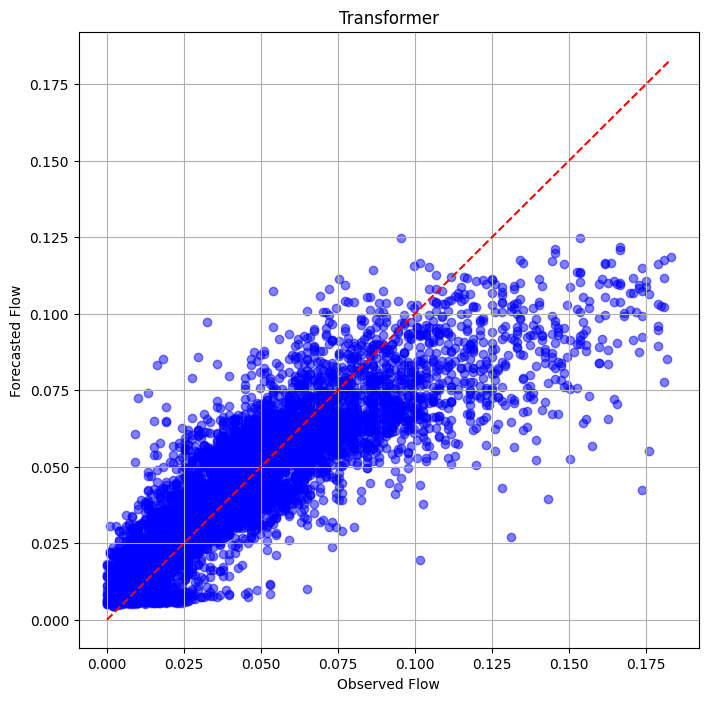

In [19]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Forecasted Flow')
plt.grid(True)
plt.show()

In [20]:
best_model.save('Kathmandu_Tr.h5')

c:\Users\Dell\Desktop\MP\myenv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Optimizer Test

In [21]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adam
Learning Rate: 0.003571245353668928


In [22]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_74: 0.12047597896827253
dropout_75: 0.12047597896827253
dropout_76: 0.3346150697539766
dropout_77: 0.3346150697539766
dropout_78: 0.1
dropout_79: 0.1
dropout_80: 0.1
dropout_81: 0.1
dropout_82: 0.1
dropout_83: 0.1
dropout_84: 0.1
dropout_85: 0.1
dropout_86: 0.23003246016920273
dropout_87: 0.1


In [23]:
best_hyperparameters_dict = best_model_hyperparameters.values
worst_hyperparameters_dict = worst_model_hyperparameters.values

print("Best Hyperparameters:", best_hyperparameters_dict)
print("Worst Hyperparameters:", worst_hyperparameters_dict)

Best Hyperparameters: {'num_transformer_blocks': 6, 'head_size': 40, 'num_heads': 2, 'ff_dim': 62, 'dropout_0': 0.12047597896827253, 'dropout_1': 0.3346150697539766, 'num_mlp_layers': 2, 'mlp_units_0': 128, 'mlp_dropout_0': 0.23003246016920273, 'optimizer': 'adam', 'learning_rate': 0.003571245404268505, 'dropout_2': 0.1, 'dropout_3': 0.1, 'dropout_4': 0.1, 'dropout_5': 0.1, 'mlp_units_1': 32, 'mlp_dropout_1': 0.1}
Worst Hyperparameters: {'num_transformer_blocks': 8, 'head_size': 232, 'num_heads': 10, 'ff_dim': 34, 'dropout_0': 0.17865356341902974, 'dropout_1': 0.5605683323076734, 'num_mlp_layers': 2, 'mlp_units_0': 192, 'mlp_dropout_0': 0.10905694032224542, 'optimizer': 'adam', 'learning_rate': 0.005821562939768229, 'dropout_2': 0.13497382341971823, 'dropout_3': 0.34481842472233504, 'dropout_4': 0.3197935459621283, 'dropout_5': 0.33207564889919794, 'mlp_units_1': 32, 'mlp_dropout_1': 0.5300486214359065, 'mlp_units_2': 64, 'mlp_dropout_2': 0.3332242501584456, 'dropout_6': 0.1, 'dropout_

In [ ]:
# from keras.utils import plot_model
# # Visualize the model architecture and save the diagram to a file
# plot_model(best_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True

In [24]:
# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
dropout_74: 0.12047597896827253
dropout_75: 0.12047597896827253
dropout_76: 0.3346150697539766
dropout_77: 0.3346150697539766
dropout_78: 0.1
dropout_79: 0.1
dropout_80: 0.1
dropout_81: 0.1
dropout_82: 0.1
dropout_83: 0.1
dropout_84: 0.1
dropout_85: 0.1
dropout_86: 0.23003246016920273
dropout_87: 0.1


In [25]:
# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']},time: {scores['Worst Model']['testing time']}")


# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0003530932430946494, R^2: 0.6910346639706619, RMSE: 0.018790775478799416, MAE: 0.01324729434491273,time: 1.6578450202941895

Fold 2 - MSE: 0.00033955068398072616, R^2: 0.6882263051276181, RMSE: 0.0184269010954291, MAE: 0.01281841067355885,time: 2.194035768508911

Fold 3 - MSE: 0.0002962041258944133, R^2: 0.7275369905697873, RMSE: 0.017210581799997734, MAE: 0.01161748163953531,time: 3.4728384017944336

Fold 4 - MSE: 0.0002799085902146623, R^2: 0.7411501547683541, RMSE: 0.016730468917955117, MAE: 0.01150904701540814,time: 4.471161365509033

Fold 5 - MSE: 0.00030412754412126227, R^2: 0.7120761225394034, RMSE: 0.017439252969128644, MAE: 0.011631907386038733,time: 6.604595899581909
Mean MSE: 0.000
Mean MAE: 0.012
Mean RMSE: 0.018
Mean R^2: 0.712
Mean time: 3.680


In [26]:
# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)    

Optimizer: Adam
Learning Rate: 0.003571245353668928


In [ ]:
# Assuming best_model is your final trained model
# best_model.save(r'C:/Users/Administrator/Documents/GitHub/AQI_Forecasting/best_model_transformer.h5')

237/237 [==============================] - 4s 15ms/step


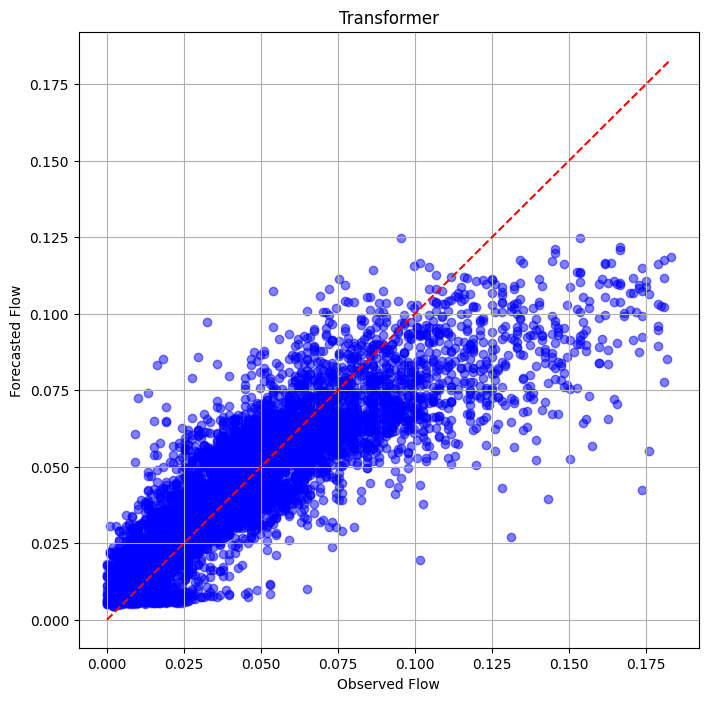

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Forecasted Flow')
plt.grid(True)
plt.show()

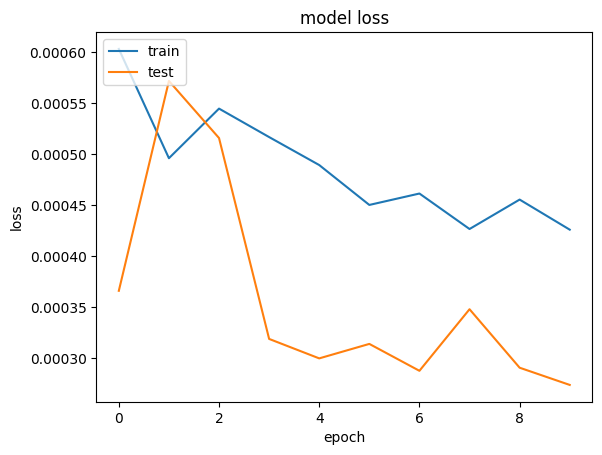

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

100 days

48/48 [==============================] - 1s 21ms/step


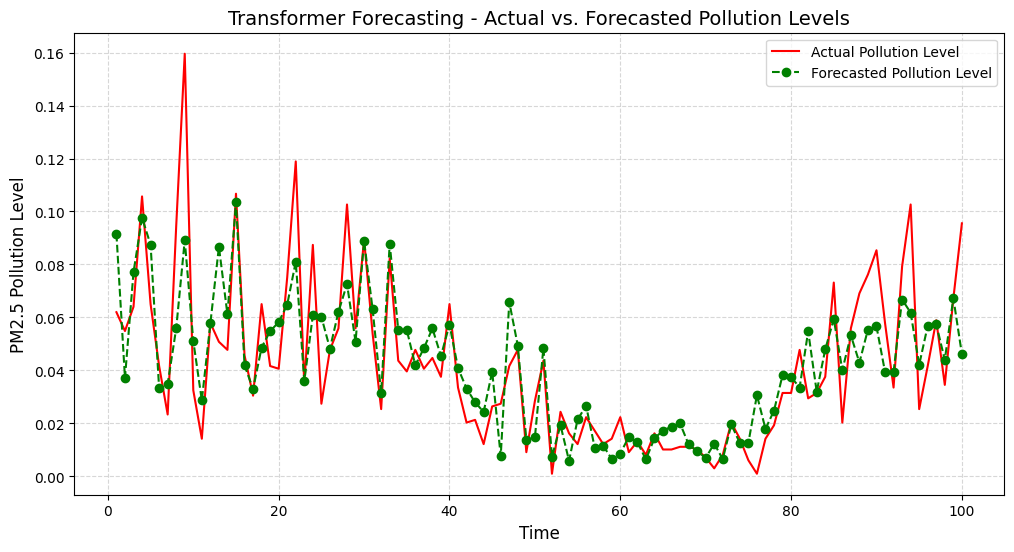

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Generate forecasted values using the best model
y_pred_best = best_model.predict(X_test_outer)

# Select 100 evenly spaced indices from the test set
num_points = 100
indices = np.linspace(0, len(y_test_outer) - 1, num_points, dtype=int)

# Subset the actual and forecasted values
time_steps = np.linspace(1, 100, num_points)  # Scale x-axis to 100 days
y_test_sampled = y_test_outer[indices]
y_pred_sampled = y_pred_best[indices]

# Define the forecasted region (last 10 points)
forecast_start = num_points - 10  # Last 10 points
forecast_x = time_steps[forecast_start:]
forecast_y_actual = y_test_sampled[forecast_start:]
forecast_y_pred = y_pred_sampled[forecast_start:]

# Plot actual pollution level in red
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_test_sampled, label="Actual Pollution Level", color="red", linestyle='solid', linewidth=1.5)

# Plot forecasted pollution level in green dashed line with markers
plt.plot(time_steps, y_pred_sampled, label="Forecasted Pollution Level", color="green", linestyle='dashed', marker='o', linewidth=1.5)

# Highlight forecasted region in shaded green
# plt.axvspan(forecast_x[0], forecast_x[-1], color='green', alpha=0.2, label="Forecasted Region")

# Labels and title
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)
plt.title("Transformer Forecasting - Actual vs. Forecasted Pollution Levels", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()

1/1 [==============================] - 0s 78ms/step


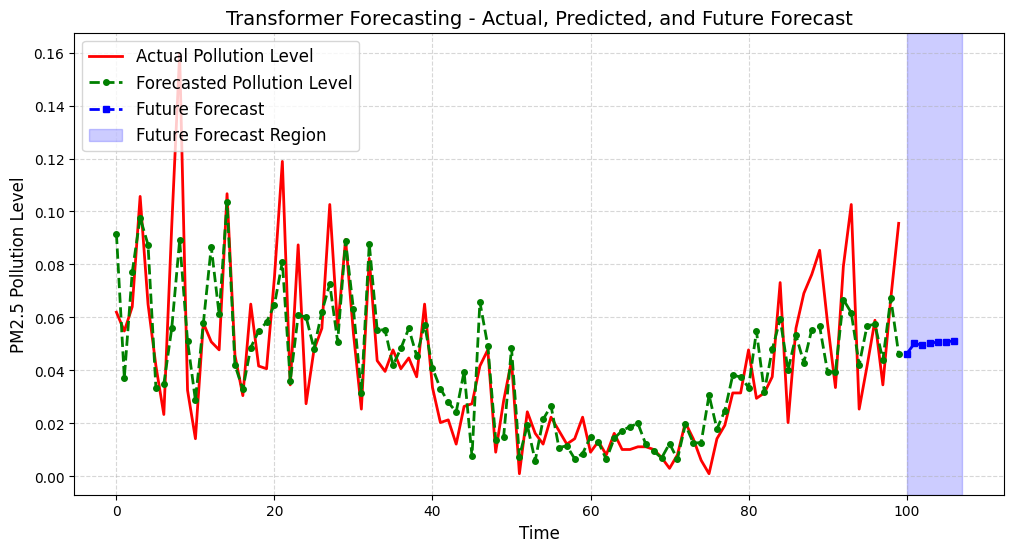

In [30]:
import numpy as np
import matplotlib.pyplot as plt

#Define the number of future days to predict
future_days = 7

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match LSTM input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
future_predictions = np.array(future_predictions)

#Plot actual vs. predicted with future forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_sampled[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred_sampled[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

#Extend time axis for future predictions
future_time = np.arange(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days)

#Plot future forecasted values
plt.plot(future_time, future_predictions, color='blue', linestyle='dashed', linewidth=2, marker='s', markersize=5, label='Future Forecast')

#Highlight the forecasted region
plt.axvspan(len(y_test_sampled[:100]), len(y_test_sampled[:100]) + future_days, color='blue', alpha=0.2, label="Future Forecast Region")

#Improve labels and title
plt.title("Transformer Forecasting - Actual, Predicted, and Future Forecast", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

#Add grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper left', fontsize=12)

#Show the plot
plt.show()

In [51]:
#Define the number of future days to predict
future_days = 7

#Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Reshape to match Transformer input

#Store predictions
future_predictions = []

for _ in range(future_days):
    next_pred = best_model.predict(input_data)  # Predict next time step
    future_predictions.append(next_pred[0, 0])  # Store the predicted PM2.5 value

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = next_pred  # Replace last value with new prediction (assumes PM2.5 is at index 0)

#Convert predictions to numpy array
future_predictions = np.array(future_predictions)

#Print forecasted values
print("Forecasted PM2.5 values for the next 7 days:", future_predictions)

1/1 [==============================] - 0s 34ms/step
Forecasted PM2.5 values for the next 7 days: [0.04619181 0.05021319 0.04952318 0.05045988 0.05061813 0.05088092
 0.05107364]


In [61]:
# Define min and max values from the original dataset (before scaling)
pm25_min = df['PM2.5'].min()
pm25_max = df['PM2.5'].max()

# Reverse MinMax scaling manually
original_predictions = (future_predictions * (pm25_max - pm25_min)) + pm25_min

print("Corrected PM2.5 Values:", original_predictions)


Corrected PM2.5 Values: [[0.04619181]
 [0.05021319]
 [0.04952318]
 [0.05045988]
 [0.05061813]
 [0.05088092]
 [0.05107364]]


In [52]:
import numpy as np

# Define the number of future days to predict
future_days = 7

# Get the last time steps from the test set as input for forecasting
input_data = X_test_outer[-1].reshape(1, X_test_outer.shape[1], X_test_outer.shape[2])  # Ensure correct input shape

# Store predictions
future_predictions = []

for _ in range(future_days):
    # Predict next time step
    next_pred = best_model.predict(input_data)

    # Extract predicted value correctly
    predicted_value = next_pred[0, 0]  # Assuming PM2.5 is at index 0

    # Store the predicted value
    future_predictions.append(predicted_value)

    # Update input data by shifting and adding new prediction
    input_data = np.roll(input_data, shift=-1, axis=1)  # Shift input data
    input_data[0, -1, 0] = predicted_value  # Update last time step with predicted PM2.5

# Convert predictions to numpy array
future_predictions = np.array(future_predictions)

# Print forecasted values
print("Forecasted PM2.5 values for the next 7 days:", future_predictions)


1/1 [==============================] - 0s 62ms/step
Forecasted PM2.5 values for the next 7 days: [0.04619181 0.05021319 0.04952318 0.05045988 0.05061813 0.05088092
 0.05107364]


In [33]:
# Convert predictions back to original scale
original_predictions = (future_predictions * std_pm) + mean_pm

print("Corrected PM2.5 Values:", original_predictions)

Corrected PM2.5 Values: [0.04794928 0.04813361 0.04810198 0.04814491 0.04815217 0.04816421
 0.04817305]


In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Assuming you used MinMaxScaler earlier
scaler = MinMaxScaler()
scaler.fit(y_train_outer.reshape(-1, 1))  # Fit using the original training data

#Convert forecasted values to a 2D array before inverse scaling
forecasted_values = np.array(future_predictions).reshape(-1, 1)

#Reverse scale the forecasted values
original_scale_forecast = scaler.inverse_transform(forecasted_values)

#Display the reversed scaled forecasted values
print("Original Scale Forecasted Values:", original_scale_forecast)

Original Scale Forecasted Values: [[84.49722 ]
 [91.8534  ]
 [90.59118 ]
 [92.304665]
 [92.59414 ]
 [93.07485 ]
 [93.42739 ]]


In [44]:
# Assuming `predictions` is the model's output (scaled values)
predictions_original = scaler.inverse_transform(forecasted_values)


In [46]:
predictions_original = scaler.inverse_transform(forecasted_values.reshape(-1, 1))
print(predictions_original)

[[0.00844972]
 [0.00918534]
 [0.00905912]
 [0.00923047]
 [0.00925941]
 [0.00930749]
 [0.00934274]]


In [53]:
scaler_pm25 = MinMaxScaler()
df[['PM2.5']] = scaler_pm25.fit_transform(df[['PM2.5']])


In [54]:
if future_predictions.size == 0:
    print("Error: No predictions were generated!")
else:
    # Reshape to ensure correct shape
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    future_predictions_original = scaler_pm25.inverse_transform(future_predictions)

    print("Forecasted PM2.5 values for the next 7 days (original scale):", future_predictions_original.flatten())


Forecasted PM2.5 values for the next 7 days (original scale): [0.04619181 0.05021319 0.04952318 0.05045988 0.05061813 0.05088092
 0.05107364]


In [55]:
# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Ensure correct shape for inverse transform

# Reverse scale the predictions
future_predictions_original = scaler_pm25.inverse_transform(future_predictions)

# Print the original PM2.5 values
print("Forecasted PM2.5 values for the next 7 days (original scale):", future_predictions_original.flatten())


Forecasted PM2.5 values for the next 7 days (original scale): [0.04619181 0.05021319 0.04952318 0.05045988 0.05061813 0.05088092
 0.05107364]


In [41]:
predictions = np.array([[0.00844972],
                         [0.00918534],
                         [0.00905912],
                         [0.00923047],
                         [0.00925941],
                         [0.00930749],
                         [0.00934274]])

# Reshape if necessary
predictions = predictions.reshape(-1, 1)

# Reverse scaling
predictions_original = scaler.inverse_transform(predictions)

print(predictions_original)


[[0.00154568]
 [0.00168025]
 [0.00165716]
 [0.0016885 ]
 [0.00169379]
 [0.00170259]
 [0.00170904]]


In [42]:
scaler_pm25 = MinMaxScaler()
df[['PM2.5']] = scaler_pm25.fit_transform(df[['PM2.5']])


In [43]:
predictions = np.array([[0.00844972],
                        [0.00918534],
                        [0.00905912],
                        [0.00923047],
                        [0.00925941],
                        [0.00930749],
                        [0.00934274]])

# Reverse scaling only for PM2.5
predictions_original = scaler_pm25.inverse_transform(predictions)

print(predictions_original)  # These are the original PM2.5 values


[[0.00154568]
 [0.00168025]
 [0.00165716]
 [0.0016885 ]
 [0.00169379]
 [0.00170259]
 [0.00170904]]


In [64]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Load the preprocessed dataset
df = pd.read_csv('original_dataset_kathmandu.csv', index_col=0)

# Define numeric columns (ensure PM2.5 is included)
numeric_columns = ['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']

# Initialize and fit MinMaxScaler again on the preprocessed dataset
scaler = MinMaxScaler()
scaler.fit(df[numeric_columns])  # Fit only on the existing scaled data


MinMaxScaler()

In [65]:
# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(-1, 1)  # Ensure correct shape

# Reverse scaling only for PM2.5
scaler_pm25 = MinMaxScaler()
scaler_pm25.fit(df[['PM2.5']])  # Fit only on PM2.5 column

original_predictions = scaler_pm25.inverse_transform(future_predictions)

print("Corrected PM2.5 Values:", original_predictions.flatten())


Corrected PM2.5 Values: [46.45274  50.40978  49.73081  50.652527 50.808235 51.066822 51.256462]


In [60]:
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense

#Define n_steps and n_features
n_steps = X_train_outer.shape[1]  # Time steps
n_features = X_train_outer.shape[2]  # Features per time step

#Define the input layer
input_layer = Input(shape=(n_steps, n_features))

#Connect the layers
x = LSTM(64, activation='relu')(input_layer)  # Example LSTM layer
output = Dense(1)(x)  # Output layer for forecasting

#Define the model
model = keras.Model(inputs=input_layer, outputs=output)

#Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Summary of the model
model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 2, 6)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,241 (71.25 KB)

 Trainable params: 18,241 (71.25 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
scaler.fit(y_train_outer.reshape(-1, 1))
output = Dense(1)(x)  # No activation for regression
model = keras.Model(inputs=input_layer, outputs=output)

#If using MinMaxScaler, ensure the scaler was fit only on the target variable
scaler = MinMaxScaler()
scaler.fit(y_train_outer.reshape(-1, 1))  # Fit only on target values

#Reverse scale the forecasted values
original_scale_forecast = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Original Scale Forecasted Values:", original_scale_forecast.flatten())

Original Scale Forecasted Values: [0.00850346 0.00902063 0.00887387 0.00892755 0.00895072 0.00892277
 0.00897069]


In [56]:
# import numpy as np


# scaler = MinMaxScaler() 


# forecast_steps = 4

# input_sequence = X_train_outer[-1]  # Last input sequence used during training


# input_sequence = input_sequence.reshape((1, input_sequence.shape[0], input_sequence.shape[1]))


# forecastedvalues = []


# for _ in range(forecast_steps):

#     next_value = model.predict(input_sequence)
 
#     forecasted_values.append(next_value[0][0])


#     next_input = np.append(input_sequence[:, 1:, :], [[next_value]], axis=1)
#     input_sequence = next_input

# forecasted_values = np.array(future_predictions)


# forecasted_values_original_scale = scaler.inverse_transform(forecasted_values.reshape(-1, 1)).flatten()

# print("Forecasted Values for Next 3-4 Days (Original Scale):", forecasted_values_original_scale)

In [57]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_outer)  # Fit scaler with the training data


# Assuming scaler is already fitted
forecast_steps = 4  # Predict next 4 days

# Get last training sequence
input_sequence = X_train_outer[-1].reshape((1, X_train_outer.shape[1], X_train_outer.shape[2]))

forecasted_values = []

for _ in range(forecast_steps):
    next_value = model.predict(input_sequence)  # Predict next step
    predicted_value = next_value[0, 0]  # Extract PM2.5

    forecasted_values.append(predicted_value)

    # Expand predicted value to match input features
    next_value_expanded = np.full((1, 1, input_sequence.shape[2]), predicted_value)

    # Shift sequence and add new prediction
    input_sequence = np.append(input_sequence[:, 1:, :], next_value_expanded, axis=1)

# Convert to NumPy array
forecasted_values = np.array(forecasted_values).reshape(-1, 1)

# Apply inverse transformation
forecasted_values_original_scale = scaler.inverse_transform(forecasted_values).flatten()

# Print results
print("Forecasted PM2.5 values for next 3-4 days:", forecasted_values_original_scale)


ValueError: Found array with dim 3. MinMaxScaler expected <= 2.